In [1]:
#Import required packages
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim

from torch.autograd import grad
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint

In [4]:
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

#Custom loss function
def loss_fun(pred, alpha=1E7):
    """Computes scalarized loss including genetic constraint and product production"""
    j1 = pred[-1][-2]
    j2 = pred[-1][-1]
    loss = j1 + alpha*j2
    return loss

class DualControl(torch.nn.Module):
    def __init__(self):
        super(DualControl, self).__init__()
        #Initialize constants, taken from Verma et al paper.
        self.Vin = 1.
        self.e0 = 0.0467
        self.lam = 1.93E-4 #1/s
        #Assume equal kinetics for all three enzymes
        self.kc = 12
        self.km = 10 #1/s

        self.W = torch.nn.Parameter(torch.tensor([[2,2],[1,1], [1E-7, 1E-7]]), requires_grad=True)
        

    def forward(self, t, y):
        '''Computes derivatives of system of differential equations'''
        dx0 = self.Vin - self.lam*y[0] - self.e0*nonlinearity(y[0], self.kc, self.km) - self.lam*y[1]
        dx1 = y[2]*nonlinearity(y[0], self.kc, self.km) - y[3]*nonlinearity(y[1], self.kc, self.km) - self.lam*y[1]
        de1 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0]) - self.lam*y[2]
        de2 = activation(y[1], self.W[2][1], self.W[1][1], self.W[0][1]) - self.lam*y[3]
        j1 = (self.Vin -  y[3]*nonlinearity(y[1], self.kc, self.km))**2
        j2 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0]) + activation(y[1], self.W[2][1], self.W[1][1], self.W[0][1])
        return torch.stack([dx0, dx1, de1, de2, j1, j2])


class DualControlEqualParams(torch.nn.Module):
    def __init__(self):
        super(DualControlEqualParams, self).__init__()
        #Initialize constants, taken from Verma et al paper.
        self.Vin = 1.
        self.e0 = 0.0467
        self.lam = 10 #1/s
        #Assume equal kinetics for all three enzymes
        self.kc = 12
        self.km = 10 #1/s

        self.W = torch.nn.Parameter(torch.tensor([[2,2],[1,1], [1E-7, 1E-7]]), requires_grad=True)
        

    def forward(self, t, y):
        '''Computes derivatives of system of differential equations'''
        dx0 = self.Vin - self.lam*y[0] - self.e0*nonlinearity(y[0], self.kc, self.km) - self.lam*y[1]
        dx1 = y[2]*nonlinearity(y[0], self.kc, self.km) - y[3]*nonlinearity(y[1], self.kc, self.km) - self.lam*y[1]
        de1 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0]) - self.lam*y[2]
        de2 = activation(y[1], self.W[2][1], self.W[1][1], self.W[0][1]) - self.lam*y[3]
        j1 = (self.Vin -  y[3]*nonlinearity(y[1], self.kc, self.km))**2
        j2 = repression(y[1], self.W[2][0], self.W[1][0], self.W[0][0]) + activation(y[1], self.W[2][1], self.W[1][1], self.W[0][1])
        return torch.stack([dx0, dx1, de1, de2, j1, j2])

class ODEFun(torch.nn.Module):
    def __init__(self):
        super(ODEFun, self).__init__()
        self.W = torch.nn.Parameter(torch.tensor([0.0, 0.0]), requires_grad=True)
        
    def forward(self, t, y):
        S, I = y
        ds = -self.W[0]*S*I
        di = self.W[1]*S*I - I
        return torch.stack([ds, di])


itr loss theta_0 theta_1
0 0.9915 1.0 1.0
10 0.9766 4.7789 -2.6134
20 0.9784 5.945 -3.9235
30 0.9805 6.3945 -5.5418
40 0.9824 6.5805 -6.6912
50 0.98 6.7115 -5.6297
60 0.9779 6.8047 -4.5647
70 0.9745 6.8816 -3.8252
80 0.976 6.9484 -3.6776
90 0.9748 6.9634 -5.7011


Pred: theta_0: 7.0, theta_1: -7.1


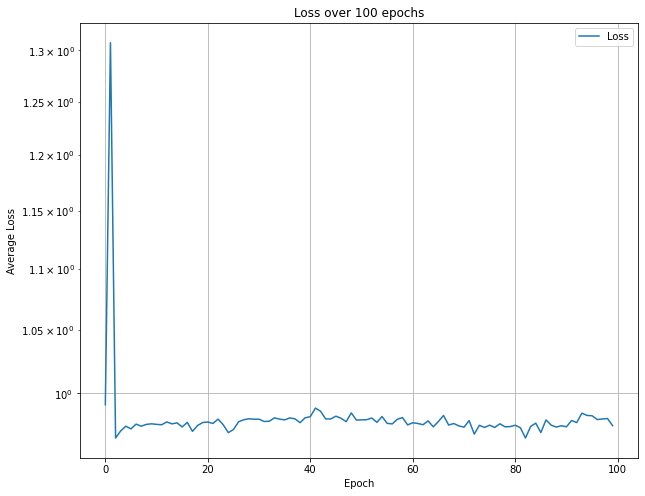

In [16]:
#HYPERPARAMETERS
func = ODEFun()
learning_rate = 1
num_iters = 100
optimizer = optim.Adam(func.parameters(), amsgrad=False, lr=learning_rate)
adjoint = False
alpha = 1E7
solver = 'dopri8'

np.random.seed(2021)
torch.manual_seed(2021)
plt.close('all')

#Establish initial conditions
t = torch.linspace(0, 100, 100) 
#true_y0 = torch.tensor([2290., 0., 0., 0., 0., 0.]) 
true_y0 = torch.tensor([0.99, 0.01])

losses =[]
print('itr loss theta_0 theta_1')
for ii in range(num_iters): 
    
    optimizer.zero_grad()
    
    if adjoint == False:
        pred = odeint(func, true_y0, t, method=solver)
    else: pred = odeint_adjoint(func, true_y0, t, method=solver)

    loss = loss_fun(pred, alpha = alpha)
    loss.backward()

    losses.append(loss.item())
    optimizer.step()
    if ii % 10 == 0:
        #print(ii, round(loss.item(), 4), round(func.W[0][0].item(), 4), round(func.W[1][0].item(), 4))
        print(ii, round(loss.item(), 4), round(func.W[0].item(), 4), round(func.W[1].item(), 4))
    

print('\n')
#print('Pred: theta_0: {:2.2}, theta_1: {:2.2}'.format(round(func.W[0][0].item(), 4), round(func.W[1][0].item(), 4)))
print('Pred: theta_0: {:2.2}, theta_1: {:2.2}'.format(round(func.W[0].item(), 4), round(func.W[1].item(), 4)))

plt.figure(figsize=(10,8))
plt.semilogy(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid()
plt.legend()
plt.title('Loss over ' + str(num_iters) + ' epochs')
plt.show()
